In [1]:
import math
import matplotlib.pyplot as plt
import random
import time
import copy
import heapq
import numpy as np

In [2]:
def get_some_randomness(l, r, elems):
    indexes=list(range(l, r))
    random.shuffle(indexes)
    return indexes[:elems]

class Vertex:
    def __init__(self, v, preve=-1, nexte=-1):
        self.value=v
        self.present=False
        if preve!=-1:
            self.present=True
        self.prev=preve
        self.next=nexte
        
    def exchange(self, preve, nexte):
        self.present=False
        if preve!=-1:
            self.present=True
        self.prev=preve
        self.next=nexte
        
    def modern_exchange(self, preve, nexte, vertexes):
        past_preve=self.prev
        past_nexte=self.next
        
        self.exchange(preve, nexte)
        if self.present==False:
            vertexes[past_preve].next=past_nexte
            vertexes[past_nexte].prev=past_preve
        else:
            vertexes[preve].next=self.value
            vertexes[nexte].prev=self.value
            
    def check_consistency(self, vertexes):
        if not self.present:
            return
        if not vertexes[self.prev].next==self.value or not vertexes[self.next].prev==self.value:
            print(f"DUPA {self.value}")
    
    def __str__(self):
        return f'{self.value}: <{self.prev}, {self.next}>'

In [3]:
class Pathway:
    def _greedy_closest_neigh_comparer(self, last, start, cur, compared):
        if self.matrix[last][compared]<self.matrix[last][cur]:
            return True
        return False
    
    def _greedy_cycle_comparer(self, last, start, cur, compared):
        if self.matrix[last][compared]+self.matrix[start][compared]<self.matrix[last][cur]+self.matrix[start][cur]:
            return True
        return False

    def _get_maxes(self, v1, v2):
        if self._maxes[0]['place']==v1 or self._maxes[0]['place']==v2:
            if self._maxes[1]['place']==v1 or self._maxes[1]['place']==v2:
                return self._maxes[2]
            return self._maxes[1]
        return self._maxes[0]
    
    def _formulate_maxes(self):
        maxes=[]
        for x in self.vertexes:
            if x.present==False:
                continue
            maxes.append({'value':self.matrix[x.prev][x.value]+self.matrix[x.value][x.next]-self.matrix[x.prev][x.next], 'place':x.value})
        self._maxes=sorted(maxes, key=lambda x: x['value'], reverse=True)[:3]
        
            
    def _double_regret(self, pathway, j, k=2, cnst=1):
        regrets=[]
        ln=len(pathway)
        for i in range(0, ln):
            v1=pathway[i]
            v2=pathway[(i+1)%ln]
            regrets.append((self.matrix[v1][j]+self.matrix[v2][j]-self.matrix[v1][v2], i))
        regrets=sorted(regrets, key=lambda x: x[0])

        sum_of_regrets=-cnst*regrets[0][0]#-regrets[0][0]
        for i in range(1, min(ln, k)):
            sum_of_regrets=sum_of_regrets+regrets[i][0]-regrets[0][0]
        return sum_of_regrets, regrets[0][1]+1


    def _general_heuristic(self, start, comparer, regrets=False, k_reg=2, cnst=1):
        ln=len(self.matrix)//2
        allez=len(self.matrix)
        last, elems, cur, path, devoured=start, 1, -1, [start], [0]*allez
        devoured[start]=1
        fortress_of_regrets=[0, -1]

        while len(path)<ln:
            for j in range(allez):
                if devoured[j]==1:
                    continue

                if regrets==True:
                    partial_regret=comparer(path, j, k_reg, cnst)
                    if cur==-1 or partial_regret[0]>fortress_of_regrets[0]:
                        fortress_of_regrets=partial_regret
                        cur=j
                if regrets==False and (cur==-1 or comparer(last, path[0], cur, j)):
                    cur=j

            last, cur=cur, -1
            devoured[last]=1
            if regrets==False:
                path.append(last)
            else:
                path.insert(fortress_of_regrets[1], last)
            fortress_of_regrets=[0, -1]
        return path
    
    def _vertex_list_to_path(self):
        ln=self.halfway
        path=[]
        for i in range(len(self.matrix)):
            if self.vertexes[i].present==False:
                continue
            j=self.vertexes[i].next
            
            path=[i, j]
            while self.vertexes[j].next!=i:
                #print(f'ideal: {i}, preve: {self.vertexes[j].prev}, zis: {j}, nexte: {self.vertexes[j].next}')
                if self.vertexes[j].next!=j:
                    j=self.vertexes[j].next
                else:
                    j=self.vertexes[j].prev
                path.append(j)
        return path
    
    def _path_to_vertex_list(self):
        ln=self.halfway
        vertexes=[]
        for i in range(len(self.matrix)):
            d=Vertex(i)
            vertexes.append(d)
            
        for i, x in enumerate(self.pathway):
            d=Vertex(x, self.pathway[(i-1)%ln], self.pathway[(i+1)%ln])
            vertexes[x]=d
        return vertexes
    
    
    #Indexes, indexes everywhere; returns literal cost (negata - profit); only one present
    def _cost_swap_vertex(self, v1, v2, bastard='None'):
        if self.vertexes[v2].present: #And its v1 present
            tmp=v1
            v1=v2
            v2=tmp
        next1=self.vertexes[v1].next
        post_next=self.vertexes[next1].next
        
        neue=self.matrix[v1][v2]+self.matrix[v2][next1]-self.matrix[v1][next1]
        eld=self._get_maxes(v1, next1)['value']
        novel=self.matrix[v1][v2]+self.matrix[v2][post_next]-self.matrix[v1][next1]-self.matrix[next1][post_next]
        
        if bastard=='None':
            return max(eld-neue, -novel)
        if bastard=='Close':
            return -novel
        if bastard=='Distant':
            return -neue
    
    #Swap v1, v2 with one outside
    def _swap_partial(self, v1, v2, bastard='None'):
        if self.vertexes[v1].present==False: #v1 exists always
            tmp=v1
            v1=v2
            v2=tmp
        next1=self.vertexes[v1].next
        post_next=self.vertexes[next1].next
        
        reason=self._get_maxes(v1, next1)
        neue=self.matrix[v1][v2]+self.matrix[v2][next1]-self.matrix[v1][next1]
        eld=reason['value']
        novel=self.matrix[v1][v2]+self.matrix[v2][post_next]-self.matrix[v1][next1]-self.matrix[next1][post_next]
        if (-novel > eld-neue and bastard!='Distant') or bastard=='Close':
            nel=next1
        else:
            nel=reason['place']
        
        self.vertexes[v2].modern_exchange(v1, next1, self.vertexes)
        self.vertexes[nel].modern_exchange(-1, -1, self.vertexes)
    
    def _swap_by_vertex(self, v1, v2):
        self._swap_partial(v1, v2)
    
    #Next edge after vertex swapped
    def _cost_swap_edges(self, v1, v2, formal_dissolver=False):
        if self.vertexes[v2].prev==v1 or self.vertexes[v2].next==v1:
            return -1
        next1=self.vertexes[v1].next
        next2=self.vertexes[v2].next
        
        neue=self.matrix[v2][v1]+self.matrix[next1][next2]
        eld= self.matrix[v2][next2]+self.matrix[v1][next1]
        if formal_dissolver==True:
            neue=self.matrix[v2][next1]+self.matrix[v1][next2]
            eld= self.matrix[v2][next2]+self.matrix[v1][next1]
        return eld-neue
        
    def _swap_by_edge(self, v1, v2):
        if self.vertexes[v2].prev==v1 or self.vertexes[v2].next==v1:
            return None
        next1=self.vertexes[v1].next
        next2=self.vertexes[v2].next
        
        j=next1
        while j!=next2:
            tmp=self.vertexes[j].prev
            self.vertexes[j].prev=self.vertexes[j].next
            self.vertexes[j].next=tmp
            j=self.vertexes[j].prev
        
        self.vertexes[next1].next=next2
        self.vertexes[next2].prev=next1
        
        self.vertexes[v1].exchange(self.vertexes[v1].prev, v2)
        self.vertexes[v2].exchange(v1, self.vertexes[v2].next)
        
    def _get_properties(self, i, j):
        if i==j or (not self.vertexes[i].present and not self.vertexes[j].present):
            return -1, -1
        if not self.vertexes[i].present or not self.vertexes[j].present:
            coste=self._cost_swap_vertex(i, j)
            return coste, self._swap_by_vertex
        else:
            coste=self._cost_swap_edges(i, j)
            return coste, self._swap_by_edge
            
    def greed(self, model_range=None):
        if model_range==None:
            model_range=list(range(0, self._full_len))
            
        while True:
            changed=False
            rn1=get_some_randomness(0, len(self.matrix), len(self.matrix))
            rn2=random.shuffle(model_range)
            
            for i in rn1:
                for j in model_range:
                    if j>=i:
                        continue
                    coste, fun=self._get_properties(i, j)
                    if coste<=0:
                        continue
                    changed=True
                    self.current_cost-=coste
                    fun(i, j)
                    self._formulate_maxes()
            if changed==False:
                return
            
        
            
    #def post_greed
    
    def execute_optimizer(self, name, params):
        _methods={
            'greed':self.greed,
            #'steep':self.steep,
            #'steep_candid':self.steep_candid,
            #'steep_heap':self.steep_heapov
        }
        _methods[name](*params)
        self.pathway=self._vertex_list_to_path()
    
    def cost(self):
        ln=self.halfway
        summa=0
        for i,x in enumerate(self.pathway):
            summa+=self.matrix[x][self.pathway[(i+1)%ln]]
        return summa
    
    
    def __init__(self, matrix, constr_method_and_args=['random'], start=-1, pathway=None):
        _methods={
            'greedy closest neigh':self._greedy_closest_neigh_comparer,
            'greedy cycle':self._greedy_cycle_comparer,
            'k regret':self._double_regret,
            'random':'random',
            'given':'given'
        }
        self.halfway=len(matrix)//2
        self._full_len=len(matrix)
        
        self.matrix=matrix
        method=_methods[constr_method_and_args[0]]
        if  method=='random':
            self.pathway=get_some_randomness(1, len(matrix), self.halfway)
        elif method=='given':
            self.pathway=pathway
        else:
            self.pathway=self._general_heuristic(start, method, *constr_method_and_args[1:])
        
        self.current_cost=self.cost()
        self.vertexes=self._path_to_vertex_list()
        self.pathway=self._vertex_list_to_path()
        self._formulate_maxes()

In [14]:
def dissolve_absolve(path, percent=0.1):
    system=path._full_len
    cut_elems=math.ceil(path.halfway*percent)
    for i in range(cut_elems):
        a, b=np.random.randint(system), np.random.randint(system)
        h, fun=path._get_properties(a, b)
        if fun!=-1:
            fun(a, b)
            path._formulate_maxes()
    path.pathway=path._vertex_list_to_path()

def swapp(a, b):
    return b, a            

def dissolve(path, ln=8, percent=0.3):
    system=path._full_len
    cut_elems=math.ceil(path.halfway*percent)
    to_cut=math.ceil(cut_elems/ln)
    removal=0
    for _ in range(to_cut):
        while True:
            a=np.random.randint(system)
            if path.vertexes[a].present==True:
                break
                
        for i in range(ln):
            nxt=path.vertexes[a].next
            path.vertexes[a].modern_exchange(-1, -1, path.vertexes)
            a=nxt
            removal+=1
            path._formulate_maxes()
    return path, removal


def move_adder(path, a, b):
    if path.vertexes[b].present==True: # a obecny
        a, b=swapp(a, b)
    nxt=path.vertexes[a].next
    return path.matrix[a][b]+path.matrix[b][nxt]-path.matrix[a][nxt]

def enchance(path, a, b):
    if path.vertexes[b].present==True:
        a, b=swapp(a, b)
    path.vertexes[b].modern_exchange(a, path.vertexes[a].next, path.vertexes)
    path._formulate_maxes()
    
def construct_reality(path, i):
    system=path._full_len
    reality=[]
    for j in range(system):
        if path.vertexes[j].present==True:
            continue
        reality.append((move_adder(path, i, j), j))
    return sorted(reality, key=lambda x: x[0])

def add_random_to_path_old(path, amount):
    system=path._full_len
    for _ in range(amount):
        a, b=np.random.randint(system), np.random.randint(system)
        while (path.vertexes[a].present^path.vertexes[b].present)==False:
            a, b=np.random.randint(system), np.random.randint(system)
        enchance(path, a, b)
        
def add_random_to_path(path, amount):
    system=path._full_len
    for _ in range(amount):
        min_cost=Inf
        a=np.random.randint(system)
        while path.vertexes[a].present==True:
            a=np.random.randint(system)
        for i in range(system):
            if path.vertexes[i].present==False:
                continue
            if min_cost > move_adder(path, a, i):
                min_cost=move_adder(path, a, i)
                b=i
        enchance(path, a, b)

def absolve(path, removed, randomized=2):
    system=path._full_len
    reality=[0]*system
    
    #Dodano losowe dodanie vertexa
    add_random_to_path_old(path, min(removed, randomized))
    removed=max(0, removed-randomized)
    
    for i in range(system):
        if path.vertexes[i].present==False:
            continue
        reality[i]=construct_reality(path, i)
    iterato=[0]*system
    
    for _ in range(removed):
        min_cost=Inf
        for i in range(system):
            if path.vertexes[i].present==False:
                continue
            
            k=iterato[i]
            while path.vertexes[reality[i][k][1]].present==True:
                k+=1
            iterato[i]=k
            
            if reality[i][k][0] < min_cost:
                min_cost = reality[i][k][0]
                a, b = i, reality[i][k][1]
            
        enchance(path, a, b)
        reality[a]=construct_reality(path, a)
        reality[b]=construct_reality(path, b)
        iterato[a]=0
        iterato[b]=0
        path._formulate_maxes()
    path.pathway=path._vertex_list_to_path()

    
def mls(iters, matrix):
        best_path=None
        costet=-1
        for i in range(iters):
            path_base=Pathway(matrix, ['random'], -1)
            path_base.execute_optimizer('greed', [])
            new_cost=path_base.cost()
            if best_path==None or costet>new_cost:
                best_path, costet=path_base, new_cost
        return best_path

def ils1_executor(path_base, elapsed):
    dissolve_absolve(path_base)
    return path_base

def ils2_executor(path_base, elapsed):
    proper=1-elapsed
    path_base, removed = dissolve(path_base, int(proper*8+3), min(max(proper*0.7, 0.05), 0.4))
    absolve(path_base, removed)
    return path_base
    
def model_exchange(zeit, matrix, system, optimize=True, stable=False):
    path_base=Pathway(matrix, ['random'], -1)
    best_path=Pathway(matrix, constr_method_and_args=['given'], pathway=path_base.pathway)
    ite=0
    last_upd=0
    
    costet=path_base.cost()
    t1=time.time()
    while time.time()-t1<zeit:
        counted=(time.time()-t1)/zeit
        ite+=1
        if optimize==True:
            path_base.execute_optimizer('greed', [])
        new_cost=path_base.cost()
        if costet>new_cost:
            last_upd=ite
            print(f'Iteration {ite}, cost {new_cost}')
            best_path, costet=Pathway(matrix, constr_method_and_args=['given'], pathway=path_base.pathway), new_cost
        elif stable==True:
            path_base=Pathway(matrix, constr_method_and_args=['given'], pathway=best_path.pathway)
        path_base=system(path_base, counted)
    print(f'Iterations: {ite}')
    return best_path

def ils1(zeit, matrix, stable=False):
    return model_exchange(zeit, matrix, ils1_executor, optimize=True, stable=stable)

def ils2(zeit, matrix, optimize=True, stable=False):
    return model_exchange(zeit, matrix, ils2_executor, optimize, stable)

In [15]:
def read_tsp(filename):
    res=[]
    with open(filename) as falka:
        x=falka.readline()
        while x:
            res.append(x)
            x=falka.readline()
    res=res[6:-1]
    res=[x[:-1].split(' ') for x in res]
    res=[[int(y) for y in x] for x in res]
    return res

def calc_matrix(res):
    C=len(res)
    matrix=[]
    for i in range(C):
        matrix.append([0]*C)

    for i in range(C):
        for j in range(C):
            matrix[i][j]=(res[i][1]-res[j][1])*(res[i][1]-res[j][1])+(res[i][2]-res[j][2])*(res[i][2]-res[j][2])
            matrix[i][j]=round(math.sqrt(matrix[i][j]))
    return matrix

def systematize(file_namez):
    properties={}
    for value in file_namez:
        x=file_namez[value]
        properties[x]={}
        properties[x]['res']=read_tsp(value)
        properties[x]['matrix']=calc_matrix(properties[x]['res'])
    return properties

    
file_namez={'../kroA200.tsp':'kroA200.tsp', '../kroB200.tsp':'kroB200.tsp'}
properties=systematize(file_namez)

In [16]:
#reality=[('greed', ['greedy closest neigh']), ('cycle', ['greedy cycle']), 
#        ('2reg-1', ['k regret', True, 2, 0]), ('2reg-2', ['k regret', True, 2, 1]), ('random', ['random'])]

Inf=1000000000
def append_starter(dct, res, iters, name='res'):
    dct['min_'+name]=min(dct['min_'+name], res)
    dct['max_'+name]=max(dct['max_'+name], res)
    dct['avg_'+name]=res/iters+dct['avg_'+name]
    
def append_later(dct, res, path, zeit, iters):
    if res<dct['min_res']:
        dct['path']=path
    append_starter(dct, res, iters)
    append_starter(dct, zeit, iters, 'time')
    
def create_fields(dct, elem, namez):
    dct[elem]={}
    for x in namez:
        dct[elem]['min_'+x]=Inf
        dct[elem]['max_'+x]=0
        dct[elem]['avg_'+x]=0

post_reality=[('random', ['random'])]
#reality=[('mls', [mls]), ('ils2_stable', [ils2, True, True]), ('ils1_stable', [ils1, True])]
reality=[('ils2_stable', [ils2, True, True])]
#reality=[('ils2a', [ils2, False, True])]

system={}

iters=10
modern_iters=100
neo_zeit={'kroA200.tsp':15.31, 'kroB200.tsp':15.71}
for y in reality:
    for falka in range(iters):
        print(f'iteracja nr {falka}')
        for x in properties:
            matrix=properties[x]['matrix']
            alpha=('random', ['random'])
            
            if (x, alpha[0], y[0]) not in system:
                create_fields(system, (x, alpha[0], y[0]), ['res', 'time'])

            t1=time.time()
            if y[0]=='mls':
                some_path=y[1][0](modern_iters, matrix) #Tu optymalizacja, tu roche-da
            else:
                #zeit=system[(x, 'random', 'mls')]['avg_time']
                zeit=neo_zeit[x]
                some_path=y[1][0](zeit, matrix, *y[1][1:])
            t2=time.time()-t1

            append_later(system[(x, alpha[0], y[0])], some_path.cost(), some_path.pathway, t2, iters)

iteracja nr 0
Iteration 1, cost 13383
Iteration 4, cost 13304
Iteration 33, cost 12941
Iteration 38, cost 12802
Iteration 66, cost 12784
Iteration 67, cost 12782
Iteration 88, cost 12773
Iteration 108, cost 12741
Iteration 133, cost 12726
Iterations: 139
Iteration 1, cost 13245
Iteration 12, cost 13092
Iteration 37, cost 12995
Iteration 42, cost 12668
Iteration 62, cost 12529
Iterations: 134
iteracja nr 1
Iteration 1, cost 14364
Iteration 4, cost 13986
Iteration 20, cost 13876
Iteration 26, cost 13284
Iteration 45, cost 12977
Iteration 74, cost 12897
Iterations: 134
Iteration 1, cost 14174
Iteration 2, cost 13875
Iteration 5, cost 13461
Iteration 10, cost 13448
Iteration 13, cost 13079
Iteration 23, cost 12885
Iteration 24, cost 12884
Iteration 49, cost 12765
Iteration 53, cost 12521
Iteration 99, cost 12406
Iteration 101, cost 12397
Iteration 116, cost 12362
Iterations: 133
iteracja nr 2
Iteration 1, cost 14917
Iteration 2, cost 14875
Iteration 3, cost 13147
Iteration 9, cost 12788
It

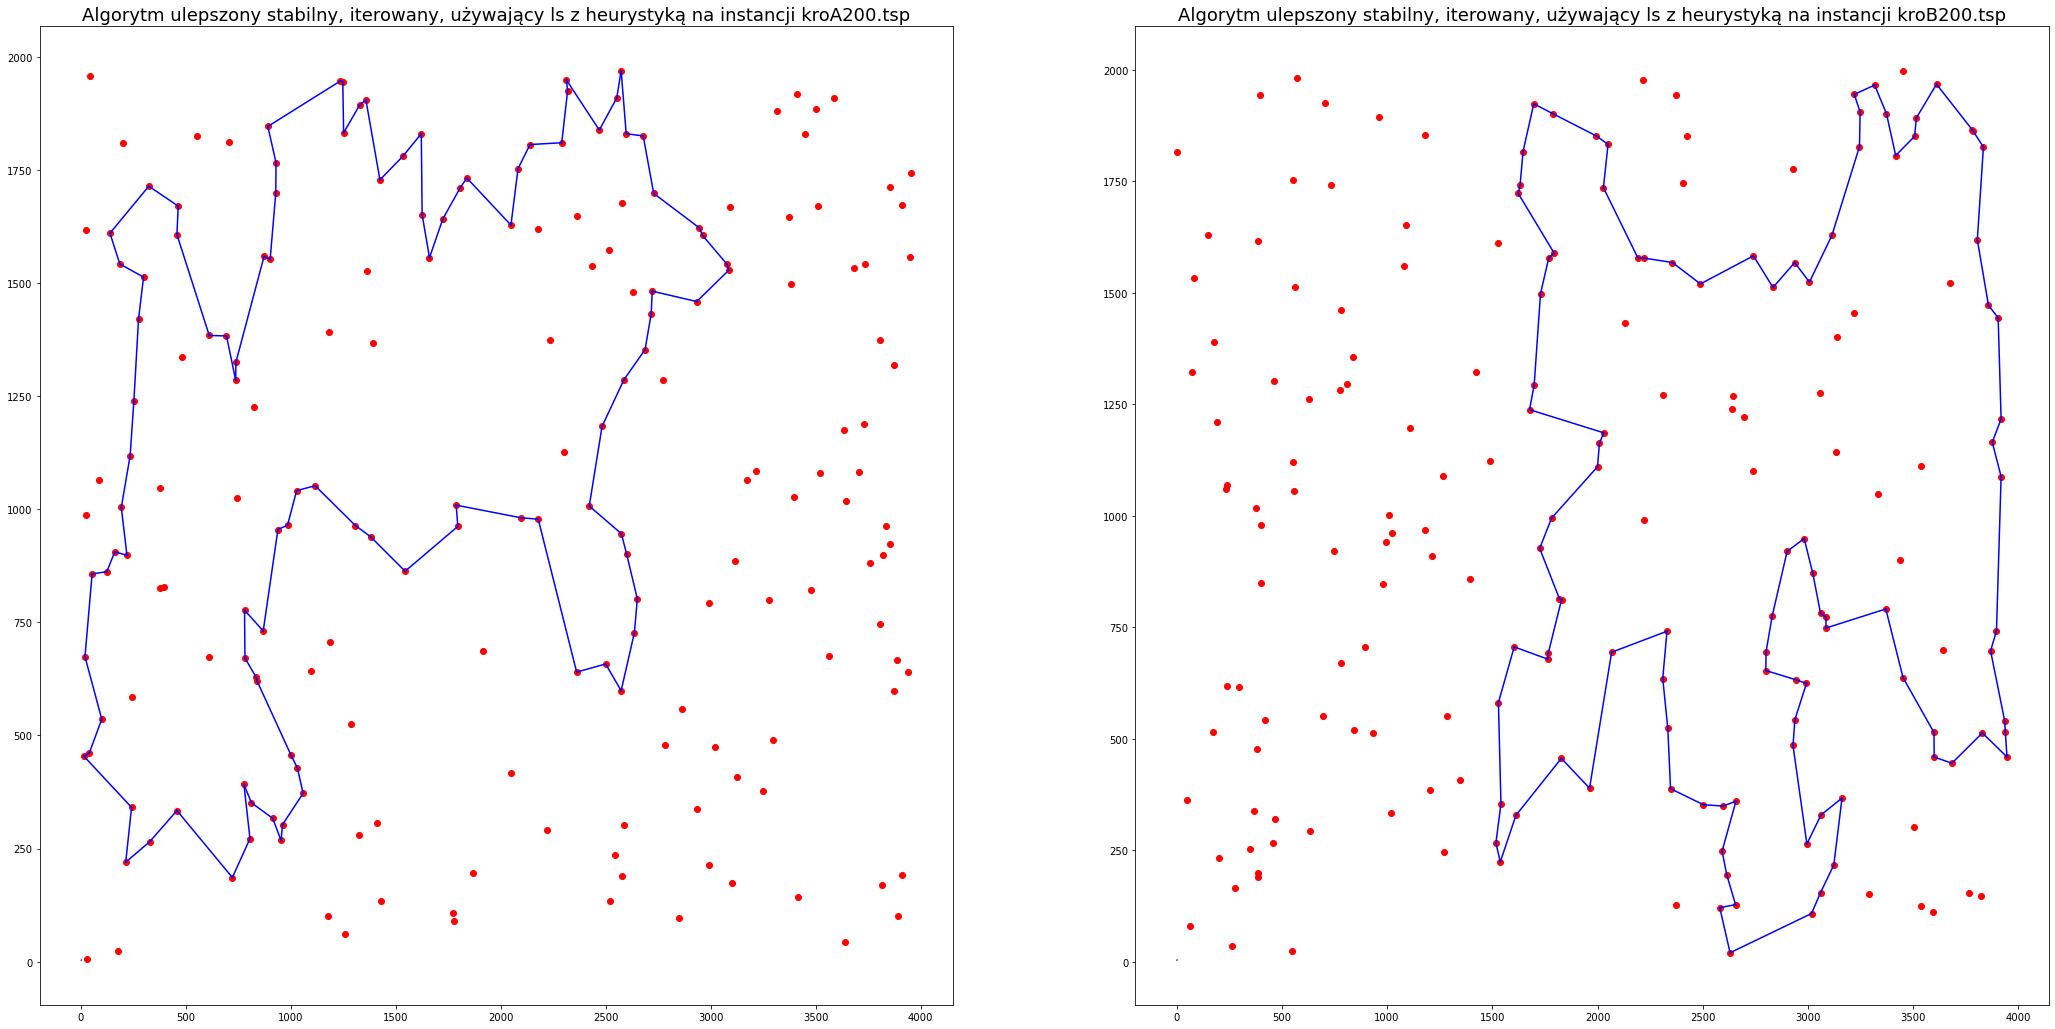

In [17]:
def print_map(res, path, ax):
    ax.plot([1,2], [3,4])
    ln=len(path)
    for x, v1 in enumerate(path):
        v2=path[(x+1)%ln]
        ax.plot([res[v1][1], res[v2][1]], [res[v1][2], res[v2][2]], color='blue')
    ax.scatter([x[1] for x in res], [x[2] for x in res], color='red')

mapp={'kroA200.tsp':0, 'kroB200.tsp':1, 
      'mls':0, 'ils1':1, 'ils1_stable':2, 'ils2':3, 'ils2a_stable':4, 'ils2_stable':0,
     'random':0, '2reg-2':1}

naming={'mls':'wielostartowy, ls', 'ils1':'iterowany, ls, random',
        'ils1_stable':'stabilny, iterowany, ls, random',
        'ils2':'iterowany, ls, heura', 'ils2a_stable':'stabilny, iterowany, bez ls',
        'ils2_stable':'ulepszony stabilny, iterowany, używający ls z heurystyką',
       'random':'losowy', '2reg-2':'2-żal 2.0'}

all_solutions=len(reality)

for y in post_reality:
    typic=18
    plots=1
    fig, ax=plt.subplots(plots, 2, figsize=(2*typic, plots*typic))
    if plots==1:
        ax=[ax]
        
    for x in system:
        if x[1]!=y[0]:
            continue
        col=mapp[x[0]]
        row=mapp[x[2]]
        print_map(properties[x[0]]['res'], system[x]['path'], ax[row][col])
        ax[row][col].set_title(f'Algorytm {naming[x[2]]} na instancji {x[0]}', size=18)
    plt.savefig(f"heury2_{y[0]}.svg", bbox_inches="tight")

In [18]:
neo_naming={
    'mls':('multistart', '-'), 'ils1':('iterowany', 'random'), 
    'ils1_stable':('ulepszony stabilny, iterowany', 'random'), 'ils2_stable':('ulepszony stabilny, iterowany', 'heura'),
    'ils2a_stable':('stabilny, iterowany, nie-ls', 'heura'), 'ils2':('iterowany', 'heura')
}

for x in system:
    print(f'{x[0]} & {neo_naming[x[2]][0]} & {neo_naming[x[2]][1]}', end='')
    for y in system[x]:
        if y!='path':
            print(f' & {system[x][y]:.2f}', end='')
    print('\\\\ \\hline')

kroA200.tsp & ulepszony stabilny, iterowany & heura & 12388.00 & 12904.00 & 12649.00 & 15.32 & 15.40 & 15.37\\ \hline
kroB200.tsp & ulepszony stabilny, iterowany & heura & 12362.00 & 13081.00 & 12595.40 & 15.72 & 15.78 & 15.76\\ \hline


In [94]:
print(system_starter)

NameError: name 'system_starter' is not defined

In [ ]:
import heapq

h = []
heapq.heappush(h, (5, {'a':['write code', "BENIZZII"], 'b':312}))
heapq.heappush(h, (7, 'release product'))
heapq.heappush(h, (1, 'write spec'))
heapq.heappush(h, (3, 'create tests'))
falka=heapq.heappop(h)
print(h, falka)

In [ ]:
def absolve(path, removed):
    system=path._full_len
    
    for i in range(system):
        if path.vertexes[i].present==False:
            continue
        for j in range(system):
            if path.vertexes[j].present==True:
                continue
            reality[i].append(move_adder(path, i, j), j)
        reality[i]=sorted(reality[i], key=lambda x: x[0])
    
    for i in range(removed):
        min_cost=Inf
        for j in range(system):
            for ij in range(j+1, system): #To zamienić przy roszadzie
                if (path.vertexes[j].present^path.vertexes[i].present)==True:
                    cost=move_adder(path, i, j)
                    if cost < min_cost:
                        min_cost, a, b=cost, i, j
        enchance(path, a, b)
    path.pathway=path._vertex_list_to_path()

In [ ]:
kroA200.tsp & stabilny, iterowany & heura & 12477.00 & 13021.00 & 12609.80 & 16.01 & 16.05 & 16.02\\ \hline
kroB200.tsp & stabilny, iterowany & heura & 12341.00 & 12852.00 & 12619.40 & 16.01 & 16.04 & 16.02\\ \hline

kroA200.tsp & stabilny, iterowany & heura & 12394.00 & 12689.00 & 12549.80 & 16.02 & 16.08 & 16.05\\ \hline
kroB200.tsp & stabilny, iterowany & heura & 12363.00 & 12813.00 & 12596.80 & 16.05 & 16.09 & 16.06\\ \hline

kroA200.tsp & stabilny, iterowany & heura & 12397.00 & 12778.00 & 12621.00 & 15.33 & 15.38 & 15.35\\ \hline
kroB200.tsp & stabilny, iterowany & heura & 12252.00 & 13027.00 & 12631.10 & 15.72 & 15.80 & 15.76\\ \hline